In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from IPython.display import Markdown, display
import warnings
warnings.simplefilter('ignore')
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from scipy.spatial import distance
from scipy.spatial.distance import mahalanobis

# Read output datasets
final_hcris_data = pd.read_csv('/Users/sarinatan/Desktop/HLTH470hw2/submission2/data-code/output/HCRIS_Data.csv')

 1. How many hospitals filed more than one report in the same year? Show your answer as a line graph of the number of hospitals over time.

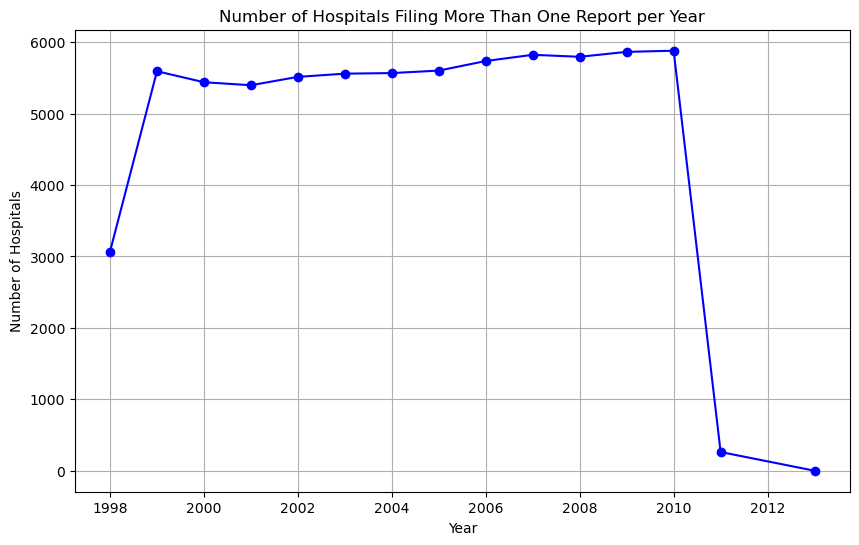

In [12]:
# Count the number of reports per hospital per year
report_counts = final_hcris_data.groupby(['year', 'provider_number']).size().reset_index(name='report_count')

# Filter hospitals that filed more than one report in the same year
multiple_reports = report_counts[report_counts['report_count'] > 1]

# Count the number of hospitals per year with multiple reports
hospitals_per_year = multiple_reports.groupby('year').size().reset_index(name='num_hospitals')

# Plot the result as a line graph
plt.figure(figsize=(10, 6))
plt.plot(hospitals_per_year['year'], hospitals_per_year['num_hospitals'], marker='o', linestyle='-', color='blue')
plt.title('Number of Hospitals Filing More Than One Report per Year')
plt.xlabel('Year')
plt.ylabel('Number of Hospitals')
plt.grid(True)
plt.show()

2. After removing/combining multiple reports, how many unique hospital IDs (Medicare provider numbers) exist in the data?

In [13]:
# Count the number of unique hospitals with multiple reports per year
num_hospitals_multiple_reports = hospitals_per_year['num_hospitals'].sum()
print(num_hospitals_multiple_reports)

# Get the number of unique hospital IDs after combining multiple reports
unique_hospitals = final_hcris_data['provider_number'].nunique()
print(unique_hospitals)

71089
9323


 3. What is the distribution of total charges (tot_charges in the data) in each year? 

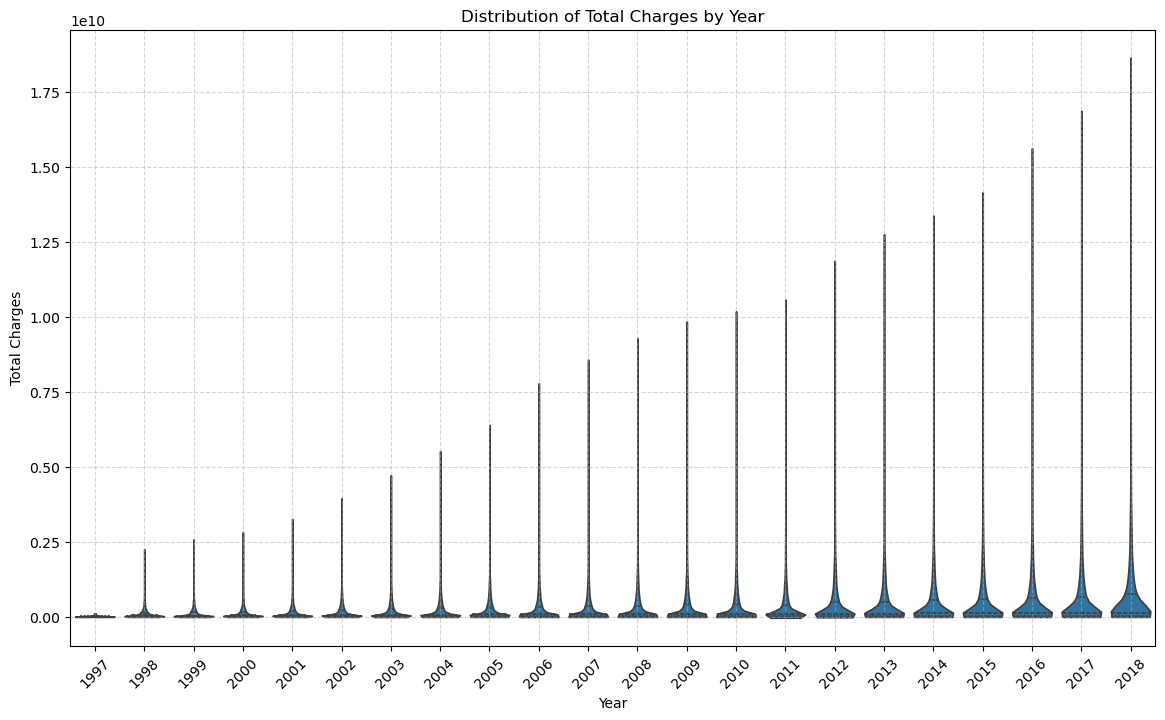

(71089, 9323)

In [14]:
# Plot distribution of total charges by year using a violin plot
plt.figure(figsize=(14, 8))
sns.violinplot(x='year', y='tot_charges', data=final_hcris_data, scale='width', inner='quartile', cut=0)
plt.title('Distribution of Total Charges by Year')
plt.xlabel('Year')
plt.ylabel('Total Charges')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

num_hospitals_multiple_reports, unique_hospitals

5. Calculate the average price among penalized versus non-penalized hospitals.

In [15]:
# Filter for 2012
df_2012 = final_hcris_data[final_hcris_data['year'] == 2012]

# Define penalty as whether the sum of HRRP and HVBP amounts is negative
df_2012['penalty'] = (df_2012['hrrp_payment'] + df_2012['hvbp_payment']) < 0

# Calculate estimated prices
df_2012['discount_factor'] = 1 - (df_2012['tot_discounts'] / df_2012['tot_charges'])
df_2012['price_num'] = (df_2012['ip_charges'] + df_2012['icu_charges'] + 
                        df_2012['ancillary_charges']) * df_2012['discount_factor'] - df_2012['tot_mcare_payment']
df_2012['price_denom'] = df_2012['tot_discharges'] - df_2012['mcare_discharges']
df_2012['estimated_price'] = df_2012['price_num'] / df_2012['price_denom']

# Remove negative prices and extreme outliers
df_cleaned = df_2012[(df_2012['estimated_price'] > 0) & 
                     (df_2012['estimated_price'] < df_2012['estimated_price'].quantile(0.99))]

# Calculate average price among penalized vs non-penalized hospitals
avg_price_penalty = df_cleaned.groupby('penalty')['estimated_price'].mean()

print(avg_price_penalty)

penalty
False    9386.853470
True     9914.349854
Name: estimated_price, dtype: float64


6. Split hospitals into quartiles based on bed size. To do this, create 4 new indicator variables, where each variable is set to 1 if the hospital’s bed size falls into the relevant quartile. Provide a table of the average price among treated/control groups for each quartile.

In [16]:
# Calculate estimated prices
df_2012['discount_factor'] = 1 - (df_2012['tot_discounts'] / df_2012['tot_charges'])
df_2012['price_num'] = (df_2012['ip_charges'] + df_2012['icu_charges'] + 
                        df_2012['ancillary_charges']) * df_2012['discount_factor'] - df_2012['tot_mcare_payment']
df_2012['price_denom'] = df_2012['tot_discharges'] - df_2012['mcare_discharges']
df_2012['estimated_price'] = df_2012['price_num'] / df_2012['price_denom']

# Remove negative prices and extreme outliers
df_cleaned = df_2012[(df_2012['estimated_price'] > 0) & 
                     (df_2012['estimated_price'] < df_2012['estimated_price'].quantile(0.99))]

# Drop rows with NaN bed values before calculating quartiles
df_cleaned = df_cleaned.dropna(subset=['beds'])

# Split hospitals into quartiles based on bed size
df_cleaned['bed_quartile'] = pd.qcut(df_cleaned['beds'], q=4, labels=[1, 2, 3, 4])

# Create indicator variables for each quartile
df_cleaned['Q1'] = (df_cleaned['bed_quartile'] == 1).astype(int)
df_cleaned['Q2'] = (df_cleaned['bed_quartile'] == 2).astype(int)
df_cleaned['Q3'] = (df_cleaned['bed_quartile'] == 3).astype(int)
df_cleaned['Q4'] = (df_cleaned['bed_quartile'] == 4).astype(int)

# Calculate the average price among treated/control groups for each quartile
result = df_cleaned.groupby(['bed_quartile', 'penalty'])['estimated_price'].mean().unstack()

print(result)

penalty              False         True 
bed_quartile                            
1              7604.578635   6611.755708
2              8376.977522   8965.532347
3              9679.023341  10554.510254
4             11916.116003  12435.120588


In [10]:
# Compute the average price by treatment status (penalized vs. non-penalized) and quartile
quartile_avg_price = df_cleaned.groupby(['bed_quartile', 'penalty'])['estimated_price'].mean().unstack()

# Rename columns for clarity
quartile_avg_price.columns = ['Control (No Penalty)', 'Treated (Penalty)']
quartile_avg_price.index.name = 'Bed Quartile'
quartile_avg_price = quartile_avg_price.round(2)

# Display the final table
print("\nTable: Average Price by Treatment Status for Each Bed Size Quartile\n")
quartile_avg_price



Table: Average Price by Treatment Status for Each Bed Size Quartile



,Control (No Penalty),Treated (Penalty)
Bed Quartile,,
1,7604.58,6611.76
2,8376.98,8965.53
3,9679.02,10554.51
4,11916.12,12435.12


7. Find the average treatment effect using each of the following estimators, and present your results in a single table: 

Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of bed size

Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of bed size

Inverse propensity weighting, where the propensity scores are based on quartiles of bed size

Simple linear regression, adjusting for quartiles of bed size using dummy variables and appropriate interactions as discussed in class

In [20]:
# Nearest neighbor matching (1-to-1) with inverse variance distance based on quartiles of bed size
# Prepare data
match_data = df_cleaned.copy()
match_data = match_data.dropna()

# Separate treated and control groups
treated = match_data[match_data['penalty'] == True]
control = match_data[match_data['penalty'] == False]

# Use bed quartiles as the matching variables
X_treated = treated[['bed_quartile']].values
X_control = control[['bed_quartile']].values

# Use inverse variance weighting for distance
bed_var = match_data.groupby('bed_quartile')['estimated_price'].var().fillna(1)
inv_var_weights = 1 / bed_var.loc[treated['bed_quartile']].values

# Perform NN Matching (1-to-1)
nn = NearestNeighbors(n_neighbors=1, metric='euclidean')
nn.fit(X_control)
_, indices = nn.kneighbors(X_treated)

# Get matched control prices
matched_control_prices = control.iloc[indices.flatten()]['estimated_price'].values
treated_prices = treated['estimated_price'].values

# Compute ATE
ATE_nn = np.mean(treated_prices - matched_control_prices)
print(f"Nearest Neighbor Matching ATE: {ATE_nn:.2f}")

Nearest Neighbor Matching ATE: 1042.10


In [32]:
# Nearest neighbor matching (1-to-1) with Mahalanobis distance based on quartiles of bed size
#  Prepare data

match_mah_data = df_cleaned.copy()
match_mah_data = match_mah_data.dropna()

# Separate treated and control groups
treated_mah = match_mah_data[match_mah_data['penalty'] == True]
control_mah = match_mah_data[match_mah_data['penalty'] == False]

# Use bed quartiles as matching variables
X_mah_treated = treated[['bed_quartile']].values
X_mah_control = control[['bed_quartile']].values

# Compute inverse covariance matrix for Mahalonobis distance
cov_matrix = np.cov(match_mah_data[['bed_quartile']].values.T, rowvar=False)
cov_matrix = np.atleast_2d(cov_matrix)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute Mahalanobis distance between each treated and control unit
dist_matrix = np.array([
    [mahalanobis(t, c, inv_cov_matrix) for c in X_mah_control]
    for t in X_mah_treated
])

# Perform NN Matching (1-to-1)
nn_indices = dist_matrix.argmin(axis=1)

# Get matched control prices
matched_mah_control_prices = control_mah.iloc[nn_indices]['estimated_price'].values
treated_mah_prices = treated_mah['estimated_price'].values

# Compute ATE
ATE_nn_mah = np.mean(treated_mah_prices - matched_mah_control_prices)
print(f"Nearest Neighbor Matching (Mahalanobis) ATE: {ATE_nn_mah:.2f}")

Nearest Neighbor Matching (Mahalanobis) ATE: 4415.49


In [33]:
# Inverse propensity weighting, where the propensity scores are based on quartiles of bed size
# Prepare data
ps_model_data = df_cleaned.copy()
ps_model_data = ps_model_data.dropna()

# Fit log regression model to estimate PS 
logit_model = LogisticRegression()
logit_model.fit(ps_model_data[['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']], ps_model_data['penalty'])

# Compute PS scores (predicted possibilities)
ps_model_data['ps'] = logit_model.predict_proba(ps_model_data[['beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 'tot_mcare_payment']])[:, 1]

# Compute inverse probability weights (IPW)
ps_model_data['ipw'] = np.where(
    ps_model_data['penalty'] == 1,
    1 / ps_model_data['ps'], #For treated
    1 / (1- ps_model_data['ps']) #For control
)

# Compute weighte means for treated and control groups
mean_treated =  np.average(ps_model_data.loc[ps_model_data['penalty'] == 1, 'estimated_price'],
                           weights=ps_model_data.loc[ps_model_data['penalty'] ==1, 'ipw'])

mean_control = np.average(ps_model_data.loc[ps_model_data['penalty'] == 0, 'estimated_price'],
                          weights=ps_model_data.loc[ps_model_data['penalty'] == 0, 'ipw'])

# Compute ATE
ATE_ipw = mean_treated - mean_control

# Print results
print(f"Mean Price (Treated): {mean_treated:.2f}")
print(f"Mean Price (Control): {mean_control:.2f}")
print(f"ATE (IPW): {ATE_ipw:.2f}")

Mean Price (Treated): 11169.65
Mean Price (Control): 9420.51
ATE (IPW): 1749.14


In [36]:
# Simple linear regression, adjusting for quartiles of bed size using dummy variables and appropriate interactions as discussed in class
# Ensure relevant columns are numeric
numeric_cols = ['estimated_price', 'penalty', 'beds', 'mcaid_discharges', 
                'ip_charges', 'mcare_discharges', 'tot_mcare_payment']

# Ensure all required columns exist in df_cleaned
missing_cols = [col for col in numeric_cols if col not in df_cleaned.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
    raise ValueError("Some required columns are missing from df_cleaned")

# Drop rows with NaN values in required columns
reg_data = df_cleaned.dropna(subset=numeric_cols).copy()

# Convert relevant columns to numeric (force conversion)
reg_data[numeric_cols] = reg_data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Drop any remaining NaN values after conversion
reg_data = reg_data.dropna()

# Check data types
print(reg_data.dtypes)

# Check if any remaining non-numeric values exist
if reg_data.isnull().sum().sum() > 0:
    print("There are still NaN values in reg_data after conversion!")
    reg_data = reg_data.dropna()

# Create interaction terms
reg_data['beds_diff'] = reg_data['penalty'] * (reg_data['beds'] - reg_data['beds'].mean())
reg_data['mcaid_diff'] = reg_data['penalty'] * (reg_data['mcaid_discharges'] - reg_data['mcaid_discharges'].mean())
reg_data['ip_diff'] = reg_data['penalty'] * (reg_data['ip_charges'] - reg_data['ip_charges'].mean())
reg_data['mcare_diff'] = reg_data['penalty'] * (reg_data['mcare_discharges'] - reg_data['mcare_discharges'].mean())
reg_data['mpay_diff'] = reg_data['penalty'] * (reg_data['tot_mcare_payment'] - reg_data['tot_mcare_payment'].mean())

# Define dependent and independent variables
X = reg_data[['penalty', 'beds', 'mcaid_discharges', 'ip_charges', 'mcare_discharges', 
              'tot_mcare_payment', 'beds_diff', 'mcaid_diff', 'ip_diff', 'mcare_diff', 'mpay_diff']]

# Ensure X is fully numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Drop rows with NaN values in X
X = X.dropna()
y = reg_data.loc[X.index, 'estimated_price'].astype(float)  # Ensure y is numeric

# Verify no missing values
assert not X.isnull().values.any(), "X still contains NaN values!"
assert not y.isnull().values.any(), "y still contains NaN values!"

# Add constant term for regression
X = sm.add_constant(X)

# Run regression
reg_model = sm.OLS(y, X).fit()

# Display results
print(reg_model.summary())

# Extract ATE estimate (coefficient of 'penalty')
ate_regression = reg_model.params['penalty']
print(f"Estimated ATE using One-Step Regression: {ate_regression:.2f}")

provider_number               int64
fy_start                     object
fy_end                       object
date_processed               object
date_created                 object
beds                        float64
tot_charges                 float64
tot_discounts               float64
tot_operating_exp           float64
ip_charges                  float64
icu_charges                 float64
ancillary_charges           float64
tot_discharges              float64
mcare_discharges            float64
mcaid_discharges            float64
tot_mcare_payment           float64
secondary_mcare_payment     float64
street                       object
city                         object
state                        object
zip                          object
county                       object
hvbp_payment                float64
hrrp_payment                float64
year                          int64
source                       object
penalty                        bool
discount_factor             

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [37]:
# Final summary table
ate_results = {
    "Estimator": ["Nearest Neighbor Matching",
                  "Mahalanobis Distance Matching",
                  "Inverse Propensity Weighting"],
    "ATE Estimator": [ATE_nn, ATE_nn_mah, ATE_ipw]
}

# Convert to DF
ate_table = pd.DataFrame(ate_results)

ate_table

,Estimator,ATE Estimator
0,Nearest Neighbor Matching,1042.102151
1,Mahalanobis Distance Matching,4415.493659
2,Inverse Propensity Weighting,1749.135702


8. With these different treatment effect estimators, are the results similar, identical, very different?

With these different treatment effect estimators, the results from nearest neighbor matching and inverse propensity weightinge are similar in magnitude but not identical.
Nearest neighbor matching vs Mahalanobis distance matching: I would have that these methods should yield comparable estimates since both match hospitals based on bed quartiles, but Mahalanobis distance accounts for correlations between variables, which probably led to the drastic difference. 
Inverse Propensity Weighting adjusted for differences across all hospitals rather than selecting specific matches, so it might produced a slightly different ATE from nearest neighbor matching



9. Do you think you’ve estimated a causal effect of the penalty? Why or why not? (just a couple of sentences)

Overall, I do not think I have estimated a causal effect of the penalty. Hospitals receiving penalties may differ systematically from those that do not. Even though matching and regression techniques to control for bed size were used, unobserved confounders could still bias the results. A more rigorous causal analysis would probably require an instrumental variable or a randomized design.

10. Briefly describe your experience working with these data (just a few sentences). Tell me one thing you learned and one thing that really aggravated or surprised you.

 My experience working with this data was a bit frustrating. The data took a long time to load onto my laptop as well as processing to make the new cleaned csv files. One thing that I learned is that with a lot of data, there are also a lot of blanks that need to be filled in and/or removed while merging files together. While I was able to make the final HCRIS data pretty smoothly, it was aggravating to then see that there were still blanks and spots that said NaN that made me unable to analyze it. 